WIP, currently only flow model

In [2]:
#ADDITIONAL DEPENDENCIES
# !pip install triangle
# !pip install rasterio
# !pip install geopy
# !pip install osmnx

   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
    --------------------------------------- 0.0/1.4 MB 108.9 kB/s eta 0:00:13
    --------------------------------------- 0.0/1.4 MB 108.9 kB/s eta 0:00:13
    --------------------------------------- 0.0/1.4 MB 108.9 kB/s eta 0:00:13
    --------------------------------------- 0.0/1.4 MB 108.9 kB/s eta 0:00:13
   - -------------------------------------- 0.0/1.4 MB 115.5 kB/s eta 0:00:12
   ----------------------------- ---------- 1.0/1.4 MB 3.3 MB/s eta 0:00:01
   ----------------------------- ---------- 1.0/1.4 MB 3.3 MB/s eta 0:00:01
   ----------------------------- ---------- 1.0/1.4 MB 3.3 MB/s eta 0:00:01
   ---------------------------------------- 1.4/1.4 MB 3.4 MB/s eta 0:00:00
   ---------------------------------------- 0.0/24.3 MB ? eta -:--:--
   --------------------------

In [1]:
import sys
import os
sys.path.append(r'C:\repos\snkit\src')
sys.path.append(r'C:\repos')
sys.path.append(r'C:\repos\ra2ce')
sys.path.append(r'C:\repos\ra2ce_multi_network')
from ci_adapt_utilities import *
from ci_adapt_classes import *
from ra2ce_multi_network.simplify_rail import *
from ra2ce_multi_network.simplify_rail import _merge_edges, _network_to_nx
import networkx as nx
import pandas as pd
from shapely import wkt, box, is_valid, make_valid
import re
from math import ceil

In [2]:
# Load configuration with ini file (created running config.py)
config_file=r'C:\repos\ci_adapt\config_ci_adapt.ini'
config = configparser.ConfigParser()
config.read(config_file)

# Set paths and data sources
p = Path('..')
hazard_type = config.get('DEFAULT', 'hazard_type')
infra_type = config.get('DEFAULT', 'infra_type')
country_code = config.get('DEFAULT', 'country_code')
country_name = config.get('DEFAULT', 'country_name')
hazard_data_subfolders = config.get('DEFAULT', 'hazard_data_subfolders')
asset_data = config.get('DEFAULT', 'asset_data')
vulnerability_data = config.get('DEFAULT', 'vulnerability_data')
data_path = Path(pathlib.Path.home().parts[0]) / 'Data'
interim_data_path = data_path / 'interim' / 'event_data_inspection'/ 'overlapping_floods_shapefiles'

In [3]:
#FUNCTION DEFINITIONS
# Create a bounding box around the graph
def get_bbox(graph):
    min_x = min([attr['pos'][0] for _, attr in graph.nodes(data=True)])
    max_x = max([attr['pos'][0] for _, attr in graph.nodes(data=True)])
    min_y = min([attr['pos'][1] for _, attr in graph.nodes(data=True)])
    max_y = max([attr['pos'][1] for _, attr in graph.nodes(data=True)])
    
    return min_x, max_x, min_y, max_y

# Assign a weight to each edge based on the length of the edge
def set_edge_weights(assets, graph):
    # Create a dictionary to store the length of each asset
    asset_lengths = {str(asset['osm_id']): asset['geometry'].length for asset_id, asset in assets.iterrows()}

    # Loop through the edges and assign the length of the asset to the edge
    for u, v, attr in graph.edges(data=True):
        if 'source_sink' in str(u) or 'source_sink' in str(v):
            continue

        # Initialize the weight and length of the edge
        attr['weight'] = int(0)
        attr['length'] = 0
        if 'osm_id' not in attr:
            continue
        
        # For concatenated edges, split the osm_id string and sum the lengths for each asset
        osm_ids = attr['osm_id'].split('; ')
        for osm_id in osm_ids:
            if osm_id in asset_lengths:
                attr['length'] += asset_lengths[osm_id]
                attr['weight'] += int(round(asset_lengths[osm_id]*1e3,0))

    return graph

def _create_terminal_graph(graph):
    # Make a copy of the graph with only the nodes identified as possible terminals
    terminal_graph = graph.copy()
    for u, attr in graph.nodes(data=True):
        if 'possible_terminal' not in graph.nodes[u]:
            continue
        if attr['possible_terminal'] == 0: 
            terminal_graph.remove_node(u)
    return terminal_graph

def shortest_paths_between_terminals(graph, route_data):
    # Make a copy of the graph with only the nodes identified as possible terminals
    terminal_graph = _create_terminal_graph(graph)

    # Create a dictionary to store the shortest path between each OD pair
    paths={}

    # Iterate over all route ODs pairs and find the shortest path between the two nodes
    for _, attr in route_data.iterrows():

        # Snap route origin and destination geometries to nearest terminal node on graph
        if wkt.loads(attr['geometry_from']).geom_type == 'Point':
            centroid_from = wkt.loads(attr['geometry_from'])
        else:
            centroid_from = wkt.loads(attr['geometry_from']).centroid
        from_nearest_node = nearest_nodes(terminal_graph, centroid_from, 1)
        if wkt.loads(attr['geometry_to']).geom_type == 'Point':
            centroid_to = wkt.loads(attr['geometry_to'])
        else:
            centroid_to = wkt.loads(attr['geometry_to']).centroid
        to_nearest_node = nearest_nodes(terminal_graph, centroid_to, 1)

        # If the nearest nodes are the same for the origin and destination, skip the route
        if from_nearest_node[0][0] == to_nearest_node[0][0]:
            continue

        # Find the shortest path between the two terminals and the average flow on the path
        try:
            shortest_path = nx.shortest_path(graph, from_nearest_node[0][0], to_nearest_node[0][0], weight='weight')
            paths[(from_nearest_node[0][0], to_nearest_node[0][0])] = (shortest_path, int(ceil(attr['goods']/52)))
                
        except nx.NetworkXNoPath:
            print(f'No path between {from_nearest_node[0][0]} and {to_nearest_node[0][0]}')
            continue               

    return paths

def set_edge_capacities(graph, route_data, simplified=False):
    

    # Find shortest paths between each OD pair
    paths=shortest_paths_between_terminals(graph, route_data)
    
    if simplified==True:
        for _,_, attr in graph.edges(data=True):
            if 'capacity' not in attr:
                attr['capacity'] = 1
        
        return graph, paths

    # Assign capacity to edges that are part of a shortest path
    for (_,_), (nodes_in_path,average_flow) in paths.items():
        for i in range(len(nodes_in_path)-1):
            if not graph.has_edge(nodes_in_path[i], nodes_in_path[i+1], 0):
                continue
            if nodes_in_path[i]=='source_sink' or nodes_in_path[i+1]=='source_sink':
                continue 
            if 'capacity' in graph[nodes_in_path[i]][nodes_in_path[i+1]][0]:
                graph[nodes_in_path[i]][nodes_in_path[i+1]][0]['capacity'] = max(graph[nodes_in_path[i]][nodes_in_path[i+1]][0]['capacity'],2*average_flow)
            else:
                graph[nodes_in_path[i]][nodes_in_path[i+1]][0]['capacity'] = 2*average_flow
    
    # Set the capacity of edges that are not on a shortest path to the median capacity
    caps=[attr['capacity'] for _, _, attr in graph.edges(data=True) if 'capacity' in attr]
    
    median_cap = int(np.median(caps))

    for _,_, attr in graph.edges(data=True):
        if 'capacity' not in attr:
            attr['capacity'] = median_cap
        
    return graph, paths

# Function to find the nearest node in a graph to a point
def nearest_nodes(graph, point, n):
    nearest_nodes = []
    for node, attr in graph.nodes(data=True):
        if 'geometry' in attr:
            distance = point.distance(attr['geometry'])
            nearest_nodes.append((node, distance))
    nearest_nodes = sorted(nearest_nodes, key=lambda x: x[1])

    return nearest_nodes[:n]

# Function to set the demand of each node based on the OD data
def set_node_demand(od_data, graph):
    # make a copy of the graph with only the nodes where possible_terminal is 1
    terminal_graph = graph.copy()
    for u, attr in graph.nodes(data=True):
        if attr['possible_terminal'] == 0: 
            terminal_graph.remove_node(u)

    # Loop through od_data and assign demand to the nearest terminal node
    for od in od_data.iterrows():
        if od[1]['geometry'].geom_type == 'Point':
            centroid = od[1]['geometry']
        else:
            centroid = od[1]['geometry'].centroid
        
        nearest_node = nearest_nodes(terminal_graph, centroid, 1)
        graph.nodes[nearest_node[0][0]]['demand'] += int(ceil((od[1]['demand']-od[1]['supply'])/52))
        
    return graph

# Function to make the net demand of the graph equal to zero (condition for minimum cost flow algorithm)
def equalize_demand_supply(graph):
    sumdem=0 
    # Calculate the total demand
    for u,attr in graph.nodes(data=True):
        if attr['demand'] !=0:
            sumdem+=int(attr['demand'])

    # Add a source_sink node with demand equal to negative the total demand, to make the demand and supply equal
    graph.add_node('source_sink', demand=int(-sumdem), pos=graph.nodes[0]['pos'])

    # Add edges from all nodes to the source_sink node
    for u, attr in graph.nodes(data=True):
        if u == 'source_sink':
            continue
        if not graph.has_edge(u, 'source_sink', 0):
            graph.add_edge(u,'source_sink', 0, weight=int(1e10))
        if not graph.has_edge('source_sink', u):
            graph.add_edge('source_sink', u, 0, weight=int(1e10))

    return graph

#Source: SA
def create_virtual_graph(graph):
    max_weight_graph = max(attr['weight'] for _, _, attr in G.edges(data=True))
    print('Max weight: '+str(max_weight_graph))
    max_capacity_graph = max(attr['capacity'] for _, _, attr in G.edges(data=True))
    print('Max capacity: '+str(max_capacity_graph))

    # create a virtual node with dummy nodes
    graph_v=graph.copy()
    # convert to int
    for u, v, key, attr in G.edges(keys=True, data=True):
        graph_v.add_edge((str(u) + '_d'), (str(v) + '_d'), **attr)

    for u in G.nodes:
        graph_v.add_edge(u,(str(u) + '_d'),capacity=max_capacity_graph*100,weight=int(round(1e10,0)))
        graph_v.add_edge((str(u) + '_d'),u,capacity=max_capacity_graph*100,weight=0)

    # verify capacities, weights and demands are integers
    edge_capacities_types, edge_weights_types, node_demands_types = inspect_graph(graph_v)
    print("Edge Capacities Types:", set(edge_capacities_types))
    print("Edge Weights Types:", set(edge_weights_types))
    print("Node Demands Types:", set(node_demands_types))
    if {type(int())} == set(list(edge_capacities_types) + list(edge_weights_types) + list(node_demands_types)):
        print('Success: only int type values')
    else: 
        print('Warning! Not all values are integers')

    return graph_v

# Function to intersect the assets with hazard polygons
def process_hazard_indirect(single_footprint, assets, geom_dict):
    hazard_name = single_footprint.parts[-1].split('.')[0]
    # load hazard map
    hazard_map = ds.read_flood_map(single_footprint)


    # convert hazard data to epsg 3857
    if '.shp' or '.geojson' in str(hazard_map):
        hazard_map=gpd.read_file(hazard_map).to_crs(3857)[['geometry']] #take only necessary columns (geometry)
    else:
        hazard_map = gpd.GeoDataFrame(hazard_map).set_crs(4326).to_crs(3857)

    # make geometries valid
    hazard_map['geometry'] = hazard_map['geometry'].apply(lambda x: make_valid(x) if not is_valid(x) else x)

    timestamp = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    print(f'{timestamp} - Coarse overlay of hazard map with assets...')

    # coarse overlay of hazard map with assets (filter out assets that do not overlay with hazard map)
    intersected_assets=ds.overlay_hazard_assets(hazard_map,assets)
    overlay_assets = pd.DataFrame(intersected_assets.T,columns=['asset','hazard_point'])

    # numpify hazard map
    hazard_numpified = hazard_map.to_numpy() #.drop('w_depth_u', axis=1).to_numpy()
    disrupted_asset_length = {}
    # loop through assets in the same area as hazard map and get damage per asset
    for asset in tqdm(overlay_assets.groupby('asset'),total=len(overlay_assets.asset.unique())): #group asset items for different hazard points per asset and get total number of unique assets
        # retrieve asset geometry and do fine overlay
        asset_geom = geom_dict[asset[0]]              

        # find the exact hazard overlays:
        get_hazard_points = hazard_numpified[asset[1]['hazard_point'].values] 
        get_hazard_points[shapely.intersects(get_hazard_points[0][0],asset_geom)]

        # estimate damage
        if len(get_hazard_points) == 0: # no overlay of asset with hazard
            print('length of get_hazard_points is 0')       

        else:
            if asset_geom.geom_type == 'LineString':
                overlay_meters = shapely.length(shapely.intersection(get_hazard_points[0][0],asset_geom)) # get the length of exposed meters per hazard cell
                disrupted_asset_length[asset[0]]=np.sum(overlay_meters) # sum the total length of exposed meters

    return disrupted_asset_length

def calculate_new_paths(graph0, shortest_paths, disrupted_edges):
    graph=graph0.copy()
    for u,v in set(disrupted_edges):
        graph.remove_edge(u,v,0)
        
    disrupted_shortest_paths={}
    for (origin,destination), (nodes_in_spath,demand) in shortest_paths.items():
        edges_in_spath=[(nodes_in_spath[i],nodes_in_spath[i+1]) for i in range(len(nodes_in_spath)-1)]
        if set(disrupted_edges).isdisjoint(edges_in_spath):
            continue
        else:
            try:
                disrupted_shortest_paths[(origin,destination)] = (nx.shortest_path(graph, origin, destination, weight='weight'), demand)
            except nx.NetworkXNoPath:
                print(f'No path between {origin} and {destination}. Cannot ship by train.')
                disrupted_shortest_paths[(origin,destination)] = (None, demand)
                continue
    
    return disrupted_shortest_paths

# Function to calculate the disrupted flow in the network
def calculate_disrupted_mcf(graph, shortest_paths, disrupted_edges, flow_dict):
    for u,v in disrupted_edges:
        graph.edges[u,v,0]['capacity']=int(0)
    
    change_in_flow={}

    for (origin,destination), (nodes_in_spath,demand) in shortest_paths.items():
        edges_in_spath=[(nodes_in_spath[i],nodes_in_spath[i+1]) for i in range(len(nodes_in_spath)-1)]
        if set(disrupted_edges).isdisjoint(edges_in_spath):
            continue
        else:
            graph.nodes[origin]['demand']=int(-demand)
            graph.nodes[destination]['demand']=int(demand)
            mcf=nx.min_cost_flow(graph)
            for u, vs in mcf.items():
                for v, flow in vs.items():
                    d_flow = flow[0]-flow_dict[(origin,destination)][u][v][0]
                    if d_flow != 0:
                        change_in_flow[(origin,destination),(u,v)] = d_flow
                            
                
            # No need to repeat for each disrupted edge in path.
            break

    return change_in_flow

# Function to calculate the economic impact of flow disruptions
def calculate_economic_impact(graph, delta_flow, average_train_load_tons, average_train_cost_per_ton_km, average_road_cost_per_ton_km):
    # Initialize the economic impact variable
    economic_impact = 0
    virtual_reduction = []
    # Loop through the edges where there is a change in flow
    for ((origin, destination),(u,v)), d_flow in delta_flow.items():
        # if 'source_sink' in str(u) or 'source_sink' in str(v):
        #     continue
        if str(u).split('_')[0] == str(v).split('_')[0]:
            continue

        # For edges that have an increase in flow, calculate the economic impact of the disruption
        if d_flow > 0:
            # If the edge is between two dummy nodes, the cost of alternate transport mode is considered (road)
            if str(u).split('_')[-1] == 'd' and str(v).split('_')[-1] == 'd':
                economic_impact += d_flow*average_train_load_tons*(average_road_cost_per_ton_km - average_train_cost_per_ton_km)*(graph.edges[u,v,0]['length']/1000)
            
            # If the edge is between to nodes in the main network, the cost of the train is considered
            elif type(u)==int and type(v)==int:
                economic_impact += d_flow*average_train_load_tons*average_train_cost_per_ton_km*(graph.edges[u,v,0]['length']/1000)
            else:
                print(f'Error in {u,v}')
        
        # For edges that have a decrease in flow, the cost is subtracted (since d_flow is negative)
        #TODO What should happen when flow through dummy nodes decreases?
        if d_flow < 0:
            if type(u)==int and type(v)==int:
                economic_impact += d_flow*average_train_load_tons*average_train_cost_per_ton_km*(graph.edges[u,v,0]['length']/1000)
            elif str(u).split('_')[-1] == 'd' and str(v).split('_')[-1] == 'd':
                virtual_reduction.append((u,v))
             
            else:
                print(f'Error in {u,v}')
            
    if len(virtual_reduction)>0:
        print(f'Flow decrease between dummy nodes: {virtual_reduction}. \nNo cost is considered.')

    return economic_impact

def calculate_economic_impact_shortest_paths(graph, shortest_paths, disrupted_shortest_paths, average_train_load_tons, average_train_cost_per_ton_km, average_road_cost_per_ton_km):
    # Initialize the economic impact variable
    economic_impact = 0
    # Loop through the edges where there is a change in flow
    for (origin, destination), (nodes_in_path, demand) in disrupted_shortest_paths.items():
        length_old_path=0
        for i in range(len(shortest_paths[(origin, destination)][0])-1):
            length_old_path += graph.edges[shortest_paths[(origin, destination)][0][i], shortest_paths[(origin, destination)][0][i+1], 0]['length']/1000
                     
        if (nodes_in_path is None) or ('_d' in str(nodes_in_path)):
            economic_impact += demand*average_train_load_tons*(average_road_cost_per_ton_km-average_train_cost_per_ton_km)*length_old_path
            continue


        else:
            length_new_path=0
            for i in range(len(nodes_in_path)-1):
                length_new_path += graph.edges[nodes_in_path[i], nodes_in_path[i+1], 0]['length']/1000
            economic_impact += demand*average_train_load_tons*average_train_cost_per_ton_km*(length_new_path-length_old_path)
        

    return economic_impact

#TODO: remove if not used
def inspect_graph(graph):
    edge_capacities_types = []
    edge_weights_types = []
    node_demands_types = []

    for _, _, attr in graph.edges(data=True):
        if 'capacity' in attr:
            edge_capacities_types.append(type(attr['capacity']))
        if 'weight' in attr:
            edge_weights_types.append(type(attr['weight']))

    for _, attr in graph.nodes(data=True):
        if 'demand' in attr:
            node_demands_types.append(type(attr['demand']))

    return edge_capacities_types, edge_weights_types, node_demands_types


In [4]:
# Read exposure data (OSM, OpenStreetMap contributors (2024) / osm-flex)
assets_path = data_path / asset_data
assets = gpd.read_file(assets_path)
assets = gpd.GeoDataFrame(assets).set_crs(4326).to_crs(3857)
print(f"{len(assets)} assets loaded.")


126925 assets loaded.


In [5]:
# Filter assets to only include railways
assets = assets.loc[assets.geometry.geom_type == 'LineString']
assets = assets.rename(columns={'railway' : 'asset'})
assets = assets[assets['asset']=='rail']
assets = assets[assets['railway:traffic_mode']!='"passenger"']
assets = assets.reset_index(drop=True)
print(f"{len(assets)} railway freight assets found.")

# Add buffer to assets to do area intersect and create dictionaries for quicker lookup
buffered_assets = ds.buffer_assets(assets)
geom_dict = assets['geometry'].to_dict()
type_dict = assets['asset'].to_dict()



114036 railway freight assets found.


In [6]:
from shapely.geometry import LineString
# Round coordinates to 0 decimal places to avoid GEOSException: TopologyException: side location conflict at x, y
def round_coordinates(line):
    rounded_coords = []
    for coord in line.coords:
        rounded_coords.append((round(coord[0], 0), round(coord[1], 0)))
    return LineString(rounded_coords)

geoms=[]
for geom in assets['geometry']:
    geoms.append(round_coordinates(geom))

assets['geometry']=geoms

In [7]:
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    #Source: Asgarpour/snkit
    # Create a railway networks with possible terminal nodes. This returns a complex network, as includes the rail tracks with the highest level of detail.
    aggregation_range = 0.08 # in km
    complex_rail_network = get_rail_network_with_terminals(network_gdf=assets, aggregation_range=aggregation_range)


In [8]:
with warnings.catch_warnings():
    try:
        warnings.simplefilter("ignore")
        merged_rail_network = merge_edges(network=complex_rail_network, excluded_edge_types=['bridge', 'tunnel']) #Must add network= to pass excluded_edge_types as a keyword argument

        # Number of nodes and edges reduced
        print(f"Difference in node counts: {complex_rail_network.nodes.shape[0] - merged_rail_network.nodes.shape[0]}")
        print(f"Difference in node counts %: {round(100*(complex_rail_network.nodes.shape[0] - merged_rail_network.nodes.shape[0])/complex_rail_network.nodes.shape[0], 0)}")
        print(f"Difference in edge counts: {complex_rail_network.edges.shape[0] - merged_rail_network.edges.shape[0]}")
        print(f"Difference in edge counts %: {round(100*(complex_rail_network.edges.shape[0] - merged_rail_network.edges.shape[0])/complex_rail_network.edges.shape[0], 0)}")
    except Exception as e:
        print(f'Exception: {e}')
        print('Skipping simplification step.')
        merged_rail_network=complex_rail_network
    
    merged_rail_graph = _network_to_nx(merged_rail_network)


Difference in node counts: 23779
Difference in node counts %: 18.0
Difference in edge counts: 24194
Difference in edge counts %: 17.0


In [9]:
merged_rail_graph = _network_to_nx(merged_rail_network)

G=nx.MultiDiGraph(merged_rail_graph)

# Initialise demand and give position to nodes
for _, attr in G.nodes(data=True):
    attr['demand'] = int(0)
    attr['pos'] = (attr['geometry'].x, attr['geometry'].y)

bbox_shape=box(*get_bbox(G))

In [10]:
# Set weights for flow model
G = set_edge_weights(assets, G)


In [11]:
# Load route data
route_data_source='C:/Data/interim/route_traffic_DEU_net_seg20.csv'
route_data = pd.read_csv(route_data_source)

# Drop rows where 'geometry_from' and 'geometry_to' are NaN
route_data = route_data.loc[route_data['geometry_from'].notnull()]
route_data = route_data.loc[route_data['geometry_to'].notnull()]

# Convert 'geometry_from' and 'geometry_to' columns to shapely geometry
route_data = route_data.loc[route_data['geometry_from'] != route_data['geometry_to']]

# Filter route data to only include routes that start and end the bounding box of the graph
route_data = route_data[route_data['geometry_from'].apply(lambda geom: bbox_shape.contains(wkt.loads(geom)))]
route_data = route_data[route_data['geometry_to'].apply(lambda geom: bbox_shape.contains(wkt.loads(geom)))]


In [12]:
# Set capacities for flow model
G, shortest_paths = set_edge_capacities(G, route_data, simplified=True)


No path between 105867 and 24456
No path between 24456 and 93723
No path between 22616 and 93722
No path between 93729 and 8846
No path between 12246 and 36269
No path between 47051 and 47093
No path between 68156 and 114644
No path between 68156 and 30036
No path between 68170 and 30036
No path between 47051 and 129466
No path between 93729 and 118254
No path between 118254 and 120476
No path between 47051 and 127707
No path between 13304 and 126633
No path between 124558 and 126633
No path between 47051 and 124788
No path between 109057 and 90711
No path between 90711 and 96813
No path between 107334 and 122212
No path between 102287 and 122212
No path between 122212 and 124788
No path between 47051 and 107334
No path between 107527 and 98845
No path between 98987 and 128830
No path between 71108 and 128830
No path between 130111 and 130107
No path between 130111 and 130109
No path between 87913 and 130109
No path between 87913 and 26202
No path between 130110 and 130111
No path betw

In [13]:
# Create initial virtual graph
G_v0=create_virtual_graph(G)


Max weight: 119546999
Max capacity: 1
Edge Capacities Types: {<class 'int'>}
Edge Weights Types: {<class 'int'>}
Node Demands Types: {<class 'int'>}
Success: only int type values


In [14]:
G_v=G_v0.copy()

In [15]:
# Define the baseline return periods 
"""
Return period definitions for Rhineland Palatinate (DERP) based on the report by Rauthe M, et al. (2020):
_H_=10-25y 
_M_=100y
_L_=200y
"""
return_period_dict = {'_H_': 10,'_M_': 100,'_L_': 200}

# Add climate change: calculate the dynamic return periods based on flat increase factors. 
# This value has been catchment-specific with frequency increasing in some regions and decreasing in others. 
# It is reasonable that in the future, the frequency will continue to change differently by catchment.

increase_factor = {
    '_H_': (1.2+9.0)/2,
    '_M_': (1.2+9.0)/2,
    '_L_': (1.2+9.0)/2 #average of the range (1.2 to 9.0) based on change since 1900
}

num_years = 100
return_periods = calculate_dynamic_return_periods(return_period_dict, num_years, increase_factor)
return_periods

{'_H_': [10.0,
  9.606147934678193,
  9.242144177449168,
  8.904719501335707,
  8.59106529209622,
  8.29875518672199,
  8.025682182985554,
  7.770007770007769,
  7.53012048192771,
  7.304601899196492,
  7.092198581560283,
  6.891798759476223,
  6.702412868632708,
  6.523157208088714,
  6.353240152477763,
  6.191950464396284,
  6.038647342995168,
  5.8927519151443715,
  5.7537399309551205,
  5.621135469364812,
  5.4945054945054945,
  5.37345513164965,
  5.257623554153523,
  5.146680391147709,
  5.040322580645161,
  4.938271604938271,
  4.84027105517909,
  4.746084480303749,
  4.655493482309124,
  4.568296025582457,
  4.484304932735426,
  4.403346543372963,
  4.325259515570934,
  4.249893752656184,
  4.177109440267334,
  4.1067761806981515,
  4.038772213247173,
  3.972983710766785,
  3.909304143862392,
  3.847633705271258,
  3.7878787878787876,
  3.729951510630362,
  3.673769287288758,
  3.6192544335866814,
  3.566333808844508,
  3.5149384885764494,
  3.465003465003465,
  3.4164673727365

In [16]:
if 'collect_output' not in locals():
    collect_output_path = f'C:/Data/interim/collected_flood_runs/sample_collected_run.pkl'
    with open(collect_output_path, 'rb') as f:
        collect_output = pickle.load(f)

collect_output


{'flood_DERP_RW_H_4326_2080410170': {(7216, 'F8.1'): (315364.7033531236,
   374887.5288691871),
  (7232, 'F8.1'): (344000.8930450563, 355114.9014931904),
  (7391, 'F8.1'): (1680.752792945015, 1680.752792945015),
  (18847, 'F8.1'): (358462.6681481806, 423420.9568322283),
  (44370, 'F8.1'): (118409.52809807166, 131127.84116905372),
  (44373, 'F8.1'): (268653.74592851236, 352019.3339087107),
  (44375, 'F8.1'): (236569.7471829724, 335810.78751917346),
  (44376, 'F8.1'): (151713.5376155815, 161754.28953843864),
  (44377, 'F8.1'): (239116.39693988612, 319919.95394882123),
  (44379, 'F8.1'): (145220.7017273908, 155338.20282238122),
  (44391, 'F8.1'): (341752.2533751037, 405939.38533580105),
  (44392, 'F8.1'): (304389.91931914125, 350382.0668801846),
  (44396, 'F8.1'): (259817.19187473488, 299645.93591322366),
  (44397, 'F8.1'): (394252.05481328914, 431551.8475451694),
  (44402, 'F8.1'): (300335.0086373359, 366332.12497785204),
  (44408, 'F8.1'): (253098.48415104137, 288391.88685988885),
  (44

In [17]:
# Define costs for different transport modes
average_train_load_tons = (896+1344+2160+1344+896+896+1344+1512+896+390)/10 # in Tons per train. Source: Kennisinstituut voor Mobiliteitsbeleid. 2023. Cost Figures for Freight Transport – final report
average_train_cost_per_ton_km = (0.014+0.018+0.047+0.045)/4 # in Euros per ton per km. Source: Kennisinstituut voor Mobiliteitsbeleid. 2023. Cost Figures for Freight Transport – final report
average_road_cost_per_ton_km = (0.395+0.375+0.246+0.203+0.138+0.153+0.125+0.103+0.122+0.099)/10 # in Euros per ton per km. Source: Kennisinstituut voor Mobiliteitsbeleid. 2023. Cost Figures for Freight Transport – final report

In [18]:
# Loop through the event files and calculate the economic impact of each event
disrupted_asset_lengths={}
disrupted_shortest_paths={}
event_impacts={}

for hazard_map, asset_dict in collect_output.items():
    disrupted_assets = [key[0] for key in asset_dict.keys()]
    disrupted_osm_ids = [
        assets.loc[asset_index]['osm_id'] 
        for asset_index in disrupted_assets 
        if asset_index in assets.index and (
            (assets.loc[asset_index]['bridge'] != 'yes') 
            and (assets.loc[asset_index]['tunnel'] != 'yes')
            and (assets.loc[asset_index]['osm_id'] is not None)
            )
        ]
    
    if len(disrupted_osm_ids)==0:
        continue

    disrupted_edges=[]
    
    for u,v,attr in G.edges(data=True):
        if 'osm_id' not in attr: 
            continue
        if attr['bridge']=='yes' or attr['tunnel']=='yes':
            continue
        matching_ids=[osm_id for osm_id in attr['osm_id'].split('; ') if osm_id in disrupted_osm_ids]
        if len(matching_ids)>0:
            disrupted_edges.append((u,v))
            
    print(f'Disrupted edges: {len(disrupted_edges)}')

    # If there are no disrupted edges in the event, move to next event
    if len(disrupted_edges)==0:
        continue
    
   
    disrupted_shortest_paths[hazard_map]=calculate_new_paths(G_v0, shortest_paths, disrupted_edges)

    if disrupted_shortest_paths[hazard_map] == {}: # No disrupted paths, no economic impact
        print(f'No shortest paths disrupted for {hazard_map}. No economic impact.')
        continue


    print('Calculating economic impact...')
    impact=calculate_economic_impact_shortest_paths(G_v, shortest_paths, disrupted_shortest_paths[hazard_map], average_train_load_tons, average_train_cost_per_ton_km, average_road_cost_per_ton_km)
    event_impacts[hazard_map]=impact
    print(hazard_map, impact)

Disrupted edges: 62
Calculating economic impact...
flood_DERP_RW_H_4326_2080410170 1937358.2864296073
Disrupted edges: 28
Calculating economic impact...
flood_DERP_RW_H_4326_2080410430 217379051.39080822
Disrupted edges: 34
Calculating economic impact...
flood_DERP_RW_H_4326_2080410540 158177.33876078334
Disrupted edges: 16
Calculating economic impact...
flood_DERP_RW_H_4326_2080410660 323626.56432379887
Disrupted edges: 4
No shortest paths disrupted for flood_DERP_RW_H_4326_2080410760. No economic impact.
Disrupted edges: 34
Calculating economic impact...
flood_DERP_RW_H_4326_2080411370 463954.99963589234
Disrupted edges: 4
No shortest paths disrupted for flood_DERP_RW_H_4326_2080416200. No economic impact.
Disrupted edges: 62
Calculating economic impact...
flood_DERP_RW_H_4326_2080416210 1255065.1079900023
Disrupted edges: 66
Calculating economic impact...
flood_DERP_RW_H_4326_2080418600 5253.504011133106
Disrupted edges: 8
No shortest paths disrupted for flood_DERP_RW_H_4326_2080418

In [19]:
event_impacts

{'flood_DERP_RW_H_4326_2080410170': 1937358.2864296073,
 'flood_DERP_RW_H_4326_2080410430': 217379051.39080822,
 'flood_DERP_RW_H_4326_2080410540': 158177.33876078334,
 'flood_DERP_RW_H_4326_2080410660': 323626.56432379887,
 'flood_DERP_RW_H_4326_2080411370': 463954.99963589234,
 'flood_DERP_RW_H_4326_2080416210': 1255065.1079900023,
 'flood_DERP_RW_H_4326_2080418600': 5253.504011133106,
 'flood_DERP_RW_H_4326_2080419180': 33201208.347757407,
 'flood_DERP_RW_H_4326_2080420240': 4539.418849509297,
 'flood_DERP_RW_H_4326_2080420340': 1560.4530359508863,
 'flood_DERP_RW_H_4326_2080421680': 176309.453549921,
 'flood_DERP_RW_H_4326_2080421770': 239304.63926028725,
 'flood_DERP_RW_H_4326_2080429430': 154326.875258882,
 'flood_DERP_RW_H_4326_2080430320': 16549.584327700766,
 'flood_DERP_RW_H_4326_2080432510': 13783.549947173546,
 'flood_DERP_RW_H_4326_2080434470': 1519416.9062002248,
 'flood_DERP_RW_H_4326_2080434490': 366383.5769128719,
 'flood_DERP_RW_H_4326_2080434630': 2452046.565686797,


In [20]:
files = [file for file in os.listdir('C:/Data/interim/collected_flood_runs') if file.endswith('.pkl') and file.startswith('overlay')]
basins_list=list(set([int(file.split('.')[0].split('_')[-1]) for file in files]))
basin_dict = {}
for basin in basins_list:
    basin_dict[basin] = {}
    for key in event_impacts.keys():
        if not str(basin) in key:
            continue
        if str(basin) in key:
            basin_dict[basin][key.split('_RW')[-1][0:3]] = event_impacts[key]


for rp in return_period_dict.keys():
    # add rp as a key to all nested dictionaries with 0 as a value if the rp is not already a key
    for basin in basin_dict.keys():
        if rp not in basin_dict[basin].keys():
            basin_dict[basin][rp] = 0

basin_dict
          

{2080428160: {'_H_': 0, '_M_': 0, '_L_': 0},
 2080438400: {'_H_': 31706.62702971368,
  '_L_': 9997822.740931826,
  '_M_': 40295.60238022833},
 2080432510: {'_H_': 13783.549947173546,
  '_L_': 3282647.206792558,
  '_M_': 13783.549947173546},
 2080431110: {'_L_': 40372773.60470156, '_M_': 40372495.75016077, '_H_': 0},
 2080431750: {'_H_': 0, '_M_': 0, '_L_': 0},
 2080410760: {'_H_': 0, '_M_': 0, '_L_': 0},
 2080436870: {'_L_': 76917.76593627328, '_M_': 73873.96172207787, '_H_': 0},
 2080421770: {'_H_': 239304.63926028725,
  '_L_': 50990387.15808034,
  '_M_': 278377.68241614115},
 2080438410: {'_H_': 2362.7198959124144,
  '_L_': 10179.463548428099,
  '_M_': 10179.463548428099},
 2080446220: {'_H_': 4753368.1570318,
  '_L_': 5937998.8332633395,
  '_M_': 5937998.8332633395},
 2080420240: {'_H_': 4539.418849509297,
  '_L_': 10572047.819337072,
  '_M_': 15379.66100524662},
 2080432400: {'_M_': 5256574.772704054, '_H_': 0, '_L_': 0},
 2080418720: {'_L_': 4261.019706381288, '_H_': 0, '_M_': 0},

In [21]:

aggregated_df_by_basin = {}
ead_by_ts_by_basin = {}

for basin, damage_dict in basin_dict.items():
    if len(damage_dict) == 0:
        continue

    aggregated_df_by_basin[basin] = pd.DataFrame.from_dict(damage_dict, orient='index', columns=['Total indirect damage'])
    aggregated_df_by_basin[basin]['Return Period'] = [return_periods[index] for index in aggregated_df_by_basin[basin].index]
    probabilities = [[1 / rp for rp in ts] for ts in aggregated_df_by_basin[basin]['Return Period']]
    aggregated_df_by_basin[basin]['Probability'] = probabilities
    dmgs = []

    for ts in range(len(probabilities[0])):    
        dmgs_m = []

        for rp in range(len(probabilities)-1):
            d_rp= probabilities[rp][ts] - probabilities[rp + 1][ts]
            trap_damage_m = 0.5 * (aggregated_df_by_basin[basin]['Total indirect damage'].iloc[rp] + aggregated_df_by_basin[basin]['Total indirect damage'].iloc[rp + 1])
            dmgs_m.append(d_rp * trap_damage_m)
        
        # Add the portion of damages corresponding to the tails of the distribution
        d0_rp = probabilities[-1][ts]
        damage_m0 = max(aggregated_df_by_basin[basin]['Total indirect damage'])
        dmgs_m.append(d0_rp * damage_m0)

        d_end_rp = (1/4)-probabilities[0][ts]
        damage_m_end = 0.5 * min(aggregated_df_by_basin[basin]['Total indirect damage'])

        dmgs_m.append(d_end_rp * damage_m_end)

        dmgs.append((sum(dmgs_m)))
    
    ead_by_ts_by_basin[basin] = pd.DataFrame(dmgs, columns=['Total indirect damage'])


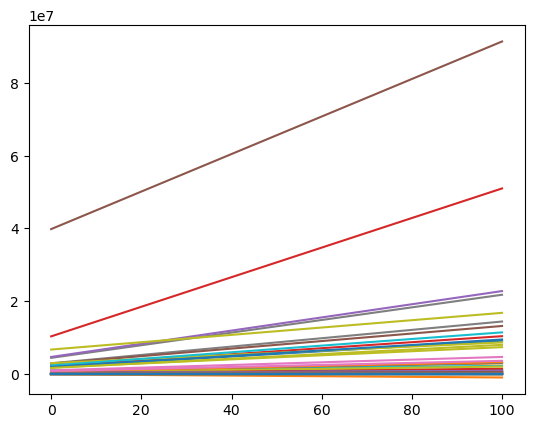

In [22]:
#plot the EAD for each basin    
from matplotlib import pyplot as plt
for basin, ead_df in ead_by_ts_by_basin.items():
    plt.plot(ead_df, label=basin)
        

In [27]:
# ead_by_ts_by_basin[2080441280]
disrupted_shortest_paths['flood_DERP_RW_H_4326_2080441280']

{(39967,
  55114): ([39967,
   16297,
   16296,
   39963,
   12883,
   29201,
   29200,
   118567,
   39955,
   29202,
   6271,
   6272,
   118809,
   6273,
   6274,
   96937,
   6281,
   6282,
   6283,
   1781,
   29179,
   29174,
   19238,
   2356,
   2355,
   19141,
   24720,
   19146,
   19068,
   19145,
   27081,
   39556,
   39943,
   19128,
   19127,
   19169,
   19168,
   96990,
   19183,
   19171,
   12842,
   12841,
   12840,
   107002,
   110153,
   110152,
   40698,
   40697,
   29550,
   16243,
   16241,
   24645,
   16268,
   16266,
   16262,
   16263,
   82224,
   115739,
   33059,
   33051,
   33076,
   33077,
   19160,
   19159,
   33293,
   115274,
   24644,
   93769,
   33177,
   34892,
   102258,
   34886,
   34885,
   35146,
   35145,
   33220,
   33804,
   33803,
   62768,
   62769,
   24695,
   24696,
   34913,
   34914,
   24700,
   24701,
   24702,
   62867,
   62892,
   62902,
   62908,
   62909,
   5951,
   16229,
   3451,
   3450,
   2154,
   2153,
   2155,


In [147]:
# Visualisation

def get_node_from_spaths(shortest_paths):
    nodes_list = []
    for key in shortest_paths.keys():
        origin, destination = key
        nodes_list.append(origin)
        nodes_list.append(destination)

    nodes_list = list(set(nodes_list))  # Remove duplicates

    return nodes_list

def from_spaths_to_edges(shortest_paths):
    edges_in_paths = []
    for (o, d), (nodes_in_path, demand) in shortest_paths.items():
        if nodes_in_path is None:
            print(f'No path found between {o} and {d}. Cannot ship by train.')
            continue
        
        edges_in_path = [(nodes_in_path[i], nodes_in_path[i+1]) for i in range(len(nodes_in_path)-1)]
        edges_in_paths.extend(edges_in_path)
    return edges_in_paths






C:\Users\peregrin\AppData\Local\Temp\ipykernel_29432\2725870815.py:51: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G_v, pos, edgelist=event_disrupted_spathedges,


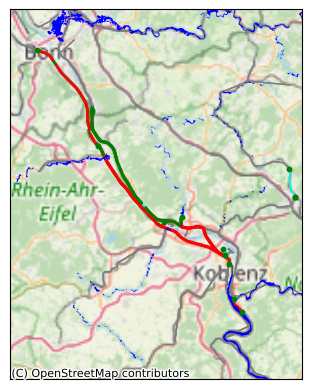

In [204]:
import contextily as ctx

# Set node positions for virtual nodes

extract_numeric_part = lambda s: int(re.search(r'\d+', s).group()) if re.search(r'\d+', s) else None
for u,attr in G_v.nodes(data=True):
    try:
        if isinstance(u, int): 
            pass
        elif isinstance(u, str): 
            if u == 'source_sink_d':
                attr['pos']=(G.nodes['source_sink']['pos'][0],G_v.nodes['source_sink']['pos'][-1])
            else:
                attr['pos']=(G_v.nodes[extract_numeric_part(u)]['pos'][0],G_v.nodes[extract_numeric_part(u)]['pos'][-1])
    except:
        print(f'Error in setting node {u} position')  

pos=nx.get_node_attributes(G_v, 'pos')

# Define edge list, od list(node list), node size, and edge width
od_list = get_node_from_spaths(shortest_paths)
edgelist=[(u, v) for u, v in G.edges(data=False) if (type(u) == int and type(v) == int)]
node_size=[int(abs(ceil(attr['demand']/10))+1) for u, attr in G.nodes(data=True) if 'demand' in attr and attr['demand'] != 0]
width=[G[u][v][0]['capacity'] for u, v in edgelist]
spaths_list = from_spaths_to_edges(shortest_paths)



for e in event_impacts_df.index:
    if e[0]!='Event_28200_DE_1970_River':continue
    
    fig, ax = plt.subplots()
    event_name = e[0]
    event_disrupted_spathedges = from_spaths_to_edges(disrupted_shortest_paths[event_name])

    nx.draw_networkx(G, pos,
            nodelist=od_list,
            edgelist=edgelist,
            with_labels=False,
            arrows=False,
            node_size=10,
            node_color='green',
            width=width,
            edge_color='grey',
            ax=ax)


    # Draw the shortest paths
    nx.draw_networkx_edges(G, pos, edgelist=spaths_list, edge_color='cyan', width=1, arrows=False, ax=ax)
#    # Draw the disrupted edges
    nx.draw_networkx_edges(G_v, pos, edgelist=event_disrupted_spathedges, 
                           edge_color=['red' if '_d' in str(u) or '_d' in str(v) else 'green' for (u,v) in event_disrupted_spathedges],
                           style='--', width=2, arrows=False, ax=ax)
    

    # Load the hazard footprint data
    hazard_data = gpd.read_file(interim_data_path / (str(e[0])+'.shp')).to_crs(3857)

    # Plot the hazard footprint
    hazard_data.plot(ax=ax, color='blue')
            
    # Add the basemap
    ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, zoom_adjust=1)

    # Set the axis limits
    ax.set_xlim([bbox_shape.bounds[0], bbox_shape.bounds[1]])
    ax.set_ylim([bbox_shape.bounds[2], bbox_shape.bounds[3]])

    # Show the plot
    plt.show()
    sleep(1)
    clear_output(wait=True)


In [ ]:
disruptions_df.sort_values(by='event_cost', ascending=False)

In [ ]:
import matplotlib.pyplot as plt

# Create a figure and subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
df=disruptions_df[disruptions_df['event_name']!='Event_28000_DE_1950_River']
# Plot 1: Cost vs Return Period
axs[0, 0].scatter(df['rp'], df['event_cost'])
axs[0, 0].set_xlabel('Return Period')
axs[0, 0].set_ylabel('Cost')

# Plot 2: Cost vs Number of Assets
axs[0, 1].scatter(df['num_disrupted_assets'], df['event_cost'])
axs[0, 1].set_xlabel('Number of Assets')
axs[0, 1].set_ylabel('Cost')

# Plot 3: Cost vs Total Length of Disrupted Assets
axs[1, 0].scatter(df['total_disrupted_length'], df['event_cost'])
axs[1, 0].set_xlabel('Total Length of Disrupted Assets')
axs[1, 0].set_ylabel('Cost')

# Plot 4: Total Length of Disrupted Assets vs Number of Assets
axs[1, 1].scatter(df['num_disrupted_assets'], df['total_disrupted_length'])
axs[1, 1].set_xlabel('Number of Assets')
axs[1, 1].set_ylabel('Total Length of Disrupted Assets')

# Adjust spacing between subplots and show the plot
plt.tight_layout()
plt.show()

In [ ]:
# disrupted_asset_lengths['Event_28000_DE_1950_River'][4829]


In [200]:
import geopandas as gpd
import lonboard as lb

name1='Event_28051_DE_1956_River'
name2='Event_28074_DE_1958_River'

# Load the GeoDataFrames
gdf1 = gpd.read_file(interim_data_path / (name1 + '.shp'))
gdf2 = gpd.read_file(interim_data_path / (name2 + '.shp'))

# lb.viz(gdf1)


layer1 = lb.PathLayer.from_geopandas(gpd.read_file(assets_path), width_min_pixels=0.8)


In [201]:
layer2 = lb.PolygonLayer.from_geopandas(
    gdf2,
    get_line_width=20,  # width in default units (meters)
    line_width_min_pixels=0.2,  # minimum width when zoomed out
    get_fill_color=[204, 251, 254],  # light blue
    get_line_color=[120, 120, 120],  # dark border color
)
map_ = lb.Map([layer1, layer2])
map_

c:\Users\peregrin\AppData\Local\anaconda3\envs\ci_adapt_env\Lib\site-packages\lonboard\_geoarrow\ops\reproject.py:97: UserWarning: Input being reprojected to EPSG:4326 CRS
  warnings.warn("Input being reprojected to EPSG:4326 CRS")


Map(layers=[PathLayer(table=pyarrow.Table
osm_id: string
railway: string
name: string
gauge: string
electrifie…

In [ ]:
#TODO: remove after testing is finalised
max_flow = 0
for origin, destinations in flow_dict.items():
    for destination, flow in destinations.items():
        max_flow = max(max_flow, max(flow.values()))
        if len(list(flow.keys())) > 1: 
            if (flow[0] > 0) and (flow[1] > 0):
                print(f'WARNING: multiple flows from {origin} to {destination}: {flow}')
        if flow[0] > 0:
            print(f"Origin: {origin} Destination: {destination} Flow: {flow[0]}")
            if origin == 'source_sink' or destination == 'source_sink':
                print("^^^SOURCE_SINK FLOW^^^")

print('Max flow: '+str(max_flow))

In [ ]:
n_sourcesink=0
n_notsourcesink=0
for u,v in G.edges(data=False):
    if not 'source_sink'in str(u) and not 'source_sink' in str(v):
        n_notsourcesink+=1
        if not (type(u)==int and type(v)==int):
            print(u,v)
    else:    
        n_sourcesink+=1     

print(f'Number of source_sink edges: {n_sourcesink}')
print(f'Number of not source_sink edges: {n_notsourcesink}')

In [ ]:
# Initialize a list to store rows
rows = []

# Iterate over the edges and add rows to the list
for i, (origin, destination, attributes) in enumerate(G_v.edges(data=True)):
    # Create a new row with the index, origin, and destination
    row = {'origin': origin, 'destination': destination}
    
    # Add each attribute as a new column
    for key, value in attributes.items():
        row['flow'] = flow_dict[origin][destination][0]
        row['disrupted_flow'] = mcf[origin][destination][0]
        row[key] = value
        
    

    # Append the row to the list
    rows.append(row)

# Convert the list of rows to a DataFrame
edges_df = pd.DataFrame(rows)
edges_df[edges_df['flow'] != edges_df['disrupted_flow']].sort_values(by='disrupted_flow', ascending=False).head(5)

In [ ]:

def delta_flow_analysis(delta_flow,event_name):
    source_sink_increase=[] # These are the flows that increase to or from the source_sink node. Highest cost nodes so only activated if the node is disconnected
    source_sink_decrease=[] # These are the flows that decrease to or from the source_sink node. 
    real_edges_increase=[] # Increase in flow on previously unsaturated edge 
    real_edges_decrease=[] # Decrease in flow 
    dummy_edges_increase=[] # Increase in flow on dummy edges if exceeding capacity
    dummy_edges_decrease=[] # Decrease in flow on dummy edges
    overflow_edges_increase=[] # Increase in flow on mixed edges 
    overflow_edges_decrease=[] # Decrease in flow on mixed edges
    for (event_name, (u,v)), d_flow in delta_flow.items():
        if 'source_sink' in str(u) or 'source_sink' in str(v):
            if d_flow > 0:
                source_sink_increase.append(((u,v),d_flow))
            if d_flow < 0:
                source_sink_decrease.append(((u,v),d_flow))
            continue
        if type(u)==int and type(v)==int:
            if d_flow > 0:
                real_edges_increase.append(((u,v),d_flow))
            if d_flow < 0:  
                real_edges_decrease.append(((u,v),d_flow))
            continue
        if str(u).split('_')[-1] == 'd' and str(v).split('_')[-1] == 'd':
            if d_flow > 0:
                dummy_edges_increase.append(((u,v),d_flow))
            if d_flow < 0:  
                dummy_edges_decrease.append(((u,v),d_flow))
            continue
        if str(u).split('_')[-1] == 'd' or str(v).split('_')[-1] == 'd':
            if d_flow > 0:
                overflow_edges_increase.append(((u,v),d_flow))
            if d_flow < 0:  
                overflow_edges_decrease.append(((u,v),d_flow))
            continue
        else:
            print(f'Error in {u,v}',end=' ')
    print(f'\n\nIncrease in flow to source_sink: {len(source_sink_increase)}')
    print(f'Decrease in flow to source_sink: {len(source_sink_decrease)}')
    print(f'Increase in flow on real edges: {len(real_edges_increase)}')
    print(f'Decrease in flow on real edges: {len(real_edges_decrease)}')
    print(f'Increase in flow on dummy edges: {len(dummy_edges_increase)}')
    print(f'Decrease in flow on dummy edges: {len(dummy_edges_decrease)}')
    print(f'Increase in flow on overflow edges: {len(overflow_edges_increase)}')
    print(f'Decrease in flow on overflow edges: {len(overflow_edges_decrease)}\n\n')
    return source_sink_increase, source_sink_decrease, real_edges_increase, real_edges_decrease, dummy_edges_increase, dummy_edges_decrease, overflow_edges_increase, overflow_edges_decrease
   

